In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from scipy.signal import find_peaks
from scipy.optimize import curve_fit



# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [3]:
j = janet.boot(uni, index=2)


In [4]:
j.prepare_data()

Already have data downloaded for Gaia ID 5311109828992983168.
If you want to check for new data, run `janet.update()`.
No postcard object will be created for this target.
No postcard object will be created for this target.


<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

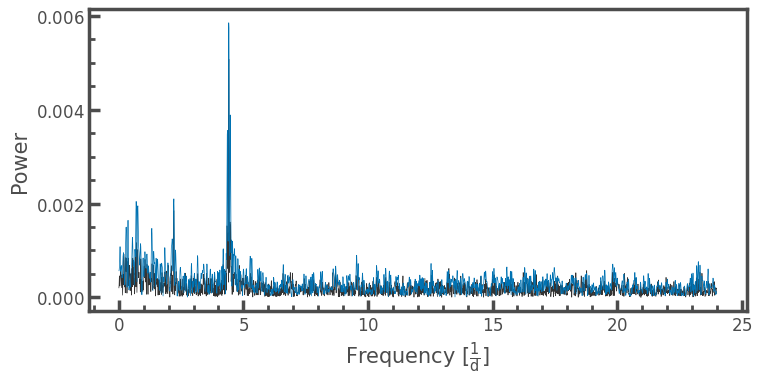

In [11]:
ax = j.void['clc_8-9'].to_periodogram().plot()
j.void['clc_8'].to_periodogram().plot(ax=ax) 
# j.void['clc_9'].to_periodogram().plot(ax=ax)

In [6]:
s = j.sectors[0]
len(s.split('-'))>1

True

In [7]:
sectors = np.arange(int(s.split('-')[0]), int(s.split('-')[-1])+1)


In [8]:
j.void[f'clc_{s}'].append(j.void[f'clc_{i}']).plot()

NameError: name 'i' is not defined

In [ ]:
sys.exit()

In [ ]:
j.run(period_range = (1., 13.))